# Navigation Project report

A number of different agent variants were created to solve the 'Banana Navigation' game. These variants included combinations of:

1. Basic Deep Queue Network using experience replay, with a linear neural network model
2. Similar to 1, but including 'Double Q-learning'
3. Building on 2, but using a 'Dueling' network
4. Prioritised experience replay

All of these implementations 'solved' the solution in so much as they achieved an average score over 100 episodes > 13 during training, one variant (prioritized experience replay with a dueling network) failed to make this score when tested over 100 episodes. The full results are shown below

As well as the above agent variants, which used the standard 37 dimensioned state, a version that used the image based states was also experimented with. Unfortunately the training results for this were inconclusive as the banana game appeared to stop working after about 600 episodes.




## Implementation notes

### Designed with the goal to make experimenting easy

A goal was to try to make it easy to try different variants by just using different hyperparameters or class implementations.

The code implemented is broadly broken down into three main areas:
- Agents classes
- NN models classes
- Experience Replay buffers classes

The agents and experience replay buffers are somewhat linked, but different neural networks models can be used with any agent.

So for example a different neural network model could be implemented and easily tested with both a normal experience replay buffer or a prioritised replay buffer and both of these configurations could utilise Double Q-Learning or not.

### Agents
A base agent class (BaseAgent) was implemented to support some common methods and attributes. Two sub classes were created, one to support basic replay buffers (where sampling of experiences was random) and the other to support priority experience type replay buffers. 

### NN Models
Any model can be used in conjunction with any of the agents implemented. Four models have been implemented:
- Basic linear model with three layers. The number of units for the two hidden layers can be provided as parameters
- Dueling linear model
- Conv2d model, specifically for the image based state
- Dueling Conv2d model, specifically for the image based state

For all networks the number of output units is equal to the number of actions, so a single forward pass can determine the action.


### Experience Replay buffers
Two replay buffers have been implemented:
- ReplayBuffer: simply stores experiences and samples randomly
- PrioritizedReplayBuffer: this uses a sumtree to manage the prioritized experiences.

#### Prioritized Replay Buffer
The experiences themselves are stored in an array, with the adjusted priorities stored in a sumtree. 

When an experience is added its priority is not initially known (as this will only happen when sampled). As described in the paper [Prioritized Experience Replay](https://arxiv.org/pdf/1511.05952.pdf) all experiences should be sampled at least once, so these experiences are initially given a maximium priority. After an experience has been sampled its priority will be updated based on the delta.

Priorities are adjusted by a constant, alpha as described in the paper.

Importance sampling weights are calculated when experiences are sampled and returned with the samples, so that the loss can be adjusted by these weights.

Both the alpha and beta (used in calculating importance sampling weights) constants are periodically adjusted. Alpha decaying slowly and beta annealing to 1. The constants for alpha and beta have been taken from the paper.

Sampling uses the priority of the experience. I divide the priority space into equal sized segments (batch size number of them) and then uniformally sample from these segments. I believe this is what the paper describes.

Prioritized experience replay did not show improved results over randomly sampled experiences, which leads me to believe that this is something wrong with my implementation. I added some instrumentation (sampled_count in experiences) to see how frequently samples were experienced to determine if there was an obvious issue, but nothing to date has come to light. 


## Learning algorithms

A variety of approaches have been experimented with, these are described below.

### Experience replay
The fundamental approach adopted is described in the paper [Human-level control through deep reinforcement
learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). The implementation uses two neural networks and an experience replay buffer.

### Double Q-learning
[Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/pdf/1509.06461.pdf) attempts to tackle the known problem of action values being overestimated in certain conditions. 
For DQN using the same values both to select and to evaluate an action makes it more likely that this overestimate will occur.
To prevent this the selection and evaluation of actions is decoupled. The selection of the action (using argmax) uses the local (online) network, whereas the evaluation uses the the target network.
In this implementation the base agent class (AgentBase) implements this feature so that it can be utilised independently of other features that may be used.

### Dueling network architectures
A duel network architecture as described in the paper [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/pdf/1511.06581.pdf) has been demonstrated to improve the performance of a reinforcment learning agent.
This approach has been implemented as the model DuelingQNetwork

### Prioritized Experience Replay
A prioritised experience replay buffer as described in the paper [Prioritized Experience Replay](https://arxiv.org/pdf/1511.05952.pdf) has been implemented.



### Hyperparameters

- Experience replay buffer size 2 ** 17 (power of 2 required for sum_tree implementation to work)
- Experience sampling batch size: 64
- Learning Rate 0.0005
- Gamma (Q learning discount factor): 0.99
- TAU (soft update of target parameters 0.001
- UPDATE_EVERY (learn every number of steps) 4
- UPDATE_MEM_PAR_EVERY (frequency of update replaying memory hypeparameters, alpha and beta 3000
- alpha 0.6 take adjusted (by min_priority) to this power
- alpha_decay_rate 0.99 
- beta 0.4 will anneal to 1 at growth rate 1.001
- beta_growth_rate 1.001
- min_priority 0.01 add to experience priorities so that none have 0 priority

- Linear Neural Network 
    - two hidden layers, each of 64 units
    - ReLU activation function for each hidden layer
    - Output layer - action size number of units 
- Dueling Neural Network
    - Duel networks, each of two hidden layers, each of 64 units
    - ReLU activation function for each hidden layer

- Convolution Neural Network
    - Layer 1
        - 32 channels
        - kernel size 8
        - stride 4
        - activation function relu

    - Layer 2
        - 64 channels
        - kernel size 4
        - stride 2
        - activation function relu

    - Layer 3
        - 64 channels
        - kernel size 3
        - stride 1
        - activation function relu

    - Linear layer 
        - 64 units
        - activation function relu

    - Linear layer
        - 64 units
        - activation function relu


## Plots of rewards for different agents

Below are plots of the performance of different agents, both from the perspective of the fastest time to learn and the best score achieved.

The agent that reached an average score of +13 over 100 consecutive episodes quickest used a uniformally sampled experience relay, a linear neural network (2 hidden layers) and double Q-learning, it achieved this in 429 episodes. This variant also managed to achieve the highest average for 100 episodes of over 16.

The worst result was using a prioritised experience replay with a dueling network, which took 679 episodes to reach the same mark.

As mentioned earlier prioritized experience replay appeared to slow learning down and reduce the best scores achieved. It's not clear if this is due to an implementation problem.


In [7]:
from unityagents import UnityEnvironment
import numpy as np
import pandas as pd
import torch
import json
import matplotlib.pyplot as plt
%matplotlib inline

from lib.agents import AgentExperienceReplay, AgentPrioritizedExperienceReplay
from lib.models import QNetwork, DuelingQNetwork
from lib.dqn import dqn


def create_dueling_model(state_size, action_size, seed):
    return DuelingQNetwork(state_size, action_size, seed)

def create_linear_model(state_size, action_size, seed):
    return QNetwork(state_size, action_size, seed)

all_scores = {}

all_scores_filename = 'scores.json'

def load_scores_from_file():
    with open(all_scores_filename) as fp:
        return json.load(fp)

def save_scores_to_file():
    with open(all_scores_filename, 'w') as fp:
        json.dump(all_scores, fp, sort_keys=True, indent=4)
        
all_scores = load_scores_from_file()
if not all_scores:
    print('no scores saved')
    all_scores = {}


## Overall best scores

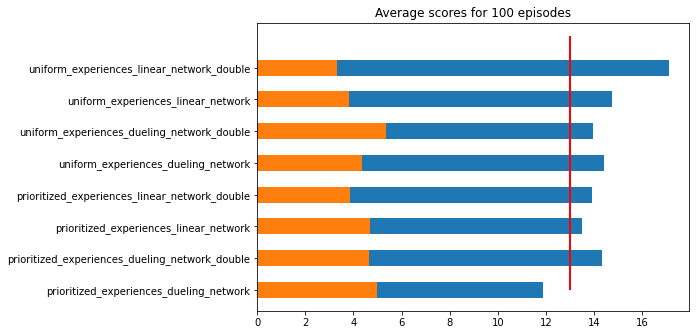

In [8]:


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

avg = [np.mean(scores) for scores in all_scores.values()]
std = [np.round(pd.DataFrame(scores).std()[0],2) for scores in all_scores.values()]
ax.barh(list(all_scores.keys()), avg, 0.5)
ax.barh(list(all_scores.keys()), std, 0.5)

#plt.hlines(y=13, xmin=0, xmax=len(avg), colors='red', linestyles='-', lw=2, label='Game solved')
plt.vlines(x=13, ymin=0, ymax=len(avg), colors='red', linestyles='-', lw=2, label='Game solved')

plt.title('Average scores for 100 episodes')
plt.show()



## Learning speed - number of episodes to reach average of > 13 for 100 episodes

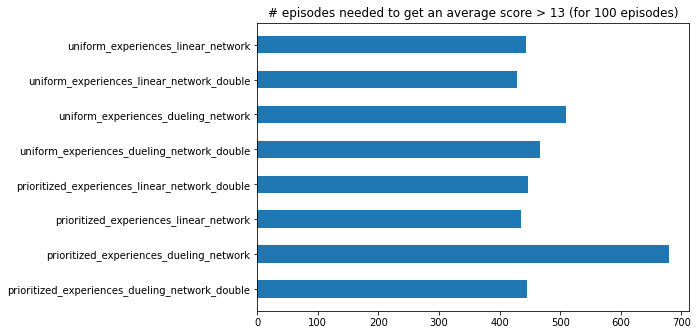

In [6]:
solved_episode_count = {
    'prioritized_experiences_dueling_network_double': 445,
    'prioritized_experiences_dueling_network': 679,
    'prioritized_experiences_linear_network': 436,
    'prioritized_experiences_linear_network_double': 447,
    'uniform_experiences_dueling_network_double': 467,
    'uniform_experiences_dueling_network': 510,
    'uniform_experiences_linear_network_double': 429,
    'uniform_experiences_linear_network': 444,
}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.barh(list(solved_episode_count.keys()), solved_episode_count.values(), 0.5)

plt.title('# episodes needed to get an average score > 13 (for 100 episodes)')
plt.show()

## Pixel Navigation

Some time was spent investigating creating an agent to learn using images of the game.

My initial approach has been to simplify the state space as the immediate impression is that two seamingly similar states of the game could produce very different states given slightly different colours. Investigating the images reveals there are a lot of different shades of yellow and blue. 
Additionally does the background in anyway add any useful information.

To try and simplify the image I used the opencv library to do the following
- convert the image from RGB to HSV as I believe this makes it easier to identify shades of a given colour
- use opencv inRange to create masks for yellow and blue regions
- identify edges and contours of the identified areas
- convert these contours to rectangles and fill with a single colour (one for yellow and one for blue)

The process generates a much simpler image, which although not extensively tested appears to reasonably represent the original image. The bananas further away, particularly yellow ones are not always picked up, but I felt this wasn't necessarily a problem and thought (with no evidence) that this was perhaps preferable to increasing the colour range and consequently getting false positives.

I also experimented with adjusting the reward proportional to the size of the largest banana rectangle of each color. I chose a reward of the area of the largest rectangle for a given color divided by the area of the image. So for yellow bananas this was a positive reward and for blue bananas a negative reward. The thinking behind this was to give an incentive to getting closer to yellow bananas. 
This experiment didn't appear to be successful based on the tests conducted so far.


### Examples of processed images

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


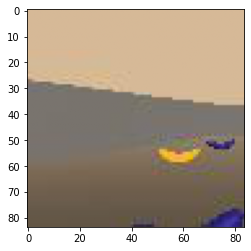

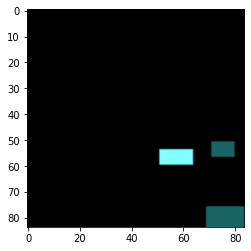

In [1]:
from unityagents import UnityEnvironment
from lib.image import process_image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


try:
    if 'env' in locals() and env._loaded:
        env.close()
except:
    pass

#env = UnityEnvironment(file_name="VisualBanana_Linux/Banana.x86_64")
env = UnityEnvironment(file_name="VisualBanana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

action_size = brain.vector_action_space_size
state = env_info.visual_observations[0]
img = np.squeeze(state)
plt.imshow(img)
plt.show()

blue_boundaries=([120,145,50], [130,255,130])
yellow_boundaries=([18, 176, 235], [22, 227, 255])

processed_image, _, _ = process_image(img,
                                colour1_boundaries=blue_boundaries,
                                colour2_boundaries=yellow_boundaries)
plt.imshow(processed_image)
plt.show()
env.close()

## More detail on the different variants

Below are the plots of different agent variants tested over 100 episodes. As can be seen the only variant to not achieve > 13 was the prioritized experiences dueling network variant.


### Dueling Network with Double Q-learning and Prioritized experience replay

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


load not implemented
Episode 100	Average Score: 14.32


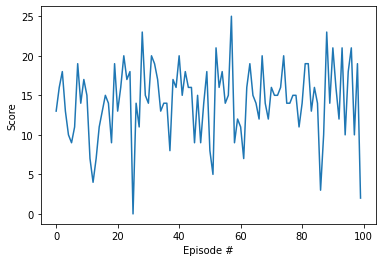

4.636003154930468

In [4]:
try:
    if 'env' in locals() and env._loaded:
        env.close()
except:
    pass

#env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
env = UnityEnvironment(file_name="Banana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

agent_name = 'prioritized_experiences_dueling_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                         create_model=create_dueling_model,
                                         double_dqn=True,
                                         train_mode=False
                                         )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

df = pd.DataFrame(all_scores[agent_name])
df.describe()
df.std()[0]

### Dueling Network with Prioritized experience replay

load not implemented
Episode 100	Average Score: 11.86


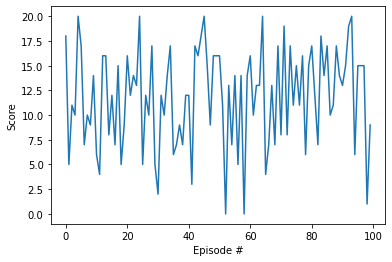

In [5]:

agent_name = 'prioritized_experiences_dueling_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                             create_model=create_dueling_model,
                                             double_dqn=False,
                                             train_mode=False
                                             )
agent.load_model(agent_name)
scores = dqn(env,
             brain_name,
             agent,
             train_mode=False,
             n_episodes=100, 
             eps_start=0.01)

all_scores[agent_name] = scores
save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with Prioritized experience replay

Episode 100	Average Score: 13.49


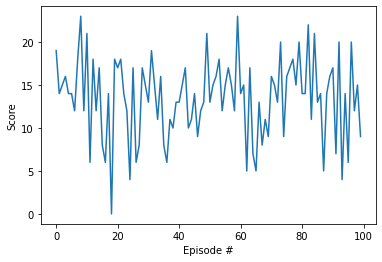

In [4]:

agent_name = 'prioritized_experiences_linear_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                             create_model=create_linear_model,
                                             double_dqn=False,
                                             train_mode=False
                                             )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with Double Q-learning and Prioritized experience replay

Episode 100	Average Score: 13.91


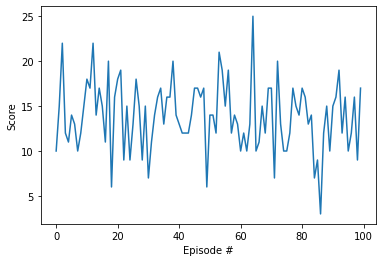

In [5]:
agent_name = 'prioritized_experiences_linear_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                             create_model=create_linear_model,
                                             double_dqn=True,
                                             train_mode=False
                                             )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Dueling Network with Double Q-learning random experience replay

Episode 100	Average Score: 13.96


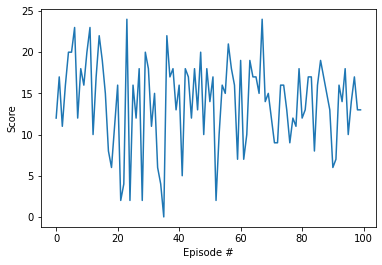

In [6]:

agent_name = 'uniform_experiences_dueling_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_dueling_model,
                                  double_dqn=True,
                                  train_mode=False
                                  )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Dueling Network  random experience replay

Episode 100	Average Score: 14.41


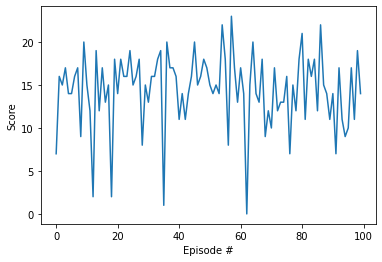

In [7]:

agent_name = 'uniform_experiences_dueling_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_dueling_model,
                                  double_dqn=False,
                                  train_mode=False
                                 )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with Double Q-learning random experience replay

Episode 100	Average Score: 17.10


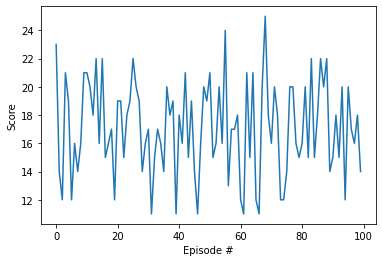

In [8]:

agent_name = 'uniform_experiences_linear_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_linear_model,
                                  double_dqn=True,
                                  train_mode=False
                                 )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with random experience replay

Episode 100	Average Score: 14.74


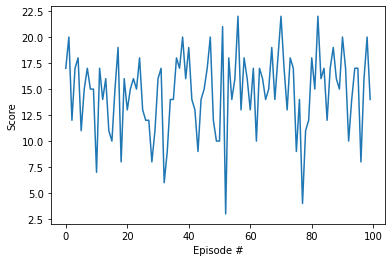

In [9]:

agent_name = 'uniform_experiences_linear_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_linear_model,
                                  double_dqn=False,
                                  train_mode=False
                                  )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Ideas for future work

### Experiment with a greater variety of Neural Network models

A lot more experimenting with different neural network models is needed, I really didn't delve into this sufficiently due to time spent implementing the various algorthims described above.

### Effective testing of subcomponents/algorithms

With a lot of software, bugs are very obvious and relatively easy to test. With ML code it's possible to implement features, e.g. prioritized experience replay, which appear to 'work', in so much that the agent learns, but the implementation may not perform as intended. Whilst this issue is not limited to ML code, it does seem particularly vulnerable as some components/algorithms may be difficult to verify.

#### Prioritized experience learning testing
This needs to be tested to verify that it is working as designed

#### Dueling Network testing
This needs to be tested to verify that it is working as designed

### Using a DQN to 'learn' the best parameters

It feels like there is a lot of trial and error in order to determine the best architecture (e.g. network model, double q-learning etc) and the best hyperparameters (alpha, beta, epsilon etc). Would it be possible to define a DQN that could be used to determine what were the best set of values. Dimensions could be limited to discrete values so that the state space was managable. The reward could be the average score from a 100 of episodes of the game.

### Image based navigation (pixel navigation)

Issues with running the VisualBanana game meant that this was not properly tested to see, given enough episodes, that it could reach the target 'solved' score. The length of time each episode took also hampered this work. It would be worth experimenting on a more powerful computer.
